In [34]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction = 0.3)
session = tf.InteractiveSession(
    config=tf.ConfigProto(gpu_options=gpu_options)
)

import json

import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
from cv2 import Canny
from PIL import Image
from mrcnn.config import Config
ROOT_DIR = os.path.abspath("../")

sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import pycocotools

from pycocotools import coco
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "Building-Detection.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")


Using TensorFlow backend.


In [35]:
class SpaceNetConfig(Config):
    '''
        Configuration for SpaceNet Dataset
    '''

    # Configuration name
    NAME = "spaceNet1"

    # I have GTX 1050 Ti, 4 GB RAM
    # It did not work with resnet101. So, I used resnet50 for backbone
    BACKBONE = 'resnet50'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    BATCH_SIZE = 32
    NUM_CLASSES = 1 + 1  # 1 (Bulding + Backround)

    # Actually, all the training data is 650x650
    # but the input size should be the multiple of 2^6
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    
    # You can change regarding to yout datset
    STEPS_PER_EPOCH = 140
    DETECTION_MAX_INSTANCES = 90
    LEARNING_RATE = 0.001
    
    VALIDATION_STEPS = 10
    
    
config = SpaceNetConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        90
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

In [36]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights('trained_weights_.h5', by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


(4, 21369, 10574)

In [108]:
from osgeo import osr, gdal
import numpy as np
raster = gdal.Open("../data/v2.tif")
raster_array = np.array(raster.ReadAsArray())
c, h, w,  = raster_array.shape
raster_array = raster_array.reshape(h, w, c)

def pixel2coord(x, y):
    xoff, a, b, yoff, d, e = raster.GetGeoTransform()

    xp = a * x + b * y + a * 0.5 + b * 0.5 + xoff
    yp = d * x + e * y + d * 0.5 + e * 0.5 + yoff
    return(xp, yp)

img_tif = raster_array
w, h= (1536, 1536)
tiles = {}
i = 0
j = 0
while i < img_tif.shape[0]:
    while j < img_tif.shape[1]:
        print (i, j)
        tile = img_tif[i:i+w, j:j+h]
        tiles[(i,j)] = (tile)
        if j+h > img_tif.shape[1]:
            j = 0
            i+=w
        elif i + w > img_tif.shape[0]:
            break
        else:
            j += h
    if i + w > img_tif.shape[0]:
        break
    

0 0
0 1536
0 3072
0 4608
0 6144
0 7680
0 9216
1536 0
1536 1536
1536 3072
1536 4608
1536 6144
1536 7680
1536 9216
3072 0
3072 1536
3072 3072
3072 4608
3072 6144
3072 7680
3072 9216
4608 0
4608 1536
4608 3072
4608 4608
4608 6144
4608 7680
4608 9216
6144 0
6144 1536
6144 3072
6144 4608
6144 6144
6144 7680
6144 9216
7680 0
7680 1536
7680 3072
7680 4608
7680 6144
7680 7680
7680 9216
9216 0
9216 1536
9216 3072
9216 4608
9216 6144
9216 7680
9216 9216
10752 0
10752 1536
10752 3072
10752 4608
10752 6144
10752 7680
10752 9216
12288 0
12288 1536
12288 3072
12288 4608
12288 6144
12288 7680
12288 9216
13824 0
13824 1536
13824 3072
13824 4608
13824 6144
13824 7680
13824 9216
15360 0
15360 1536
15360 3072
15360 4608
15360 6144
15360 7680
15360 9216
16896 0
16896 1536
16896 3072
16896 4608
16896 6144
16896 7680
16896 9216
18432 0
18432 1536
18432 3072
18432 4608
18432 6144
18432 7680
18432 9216
19968 0


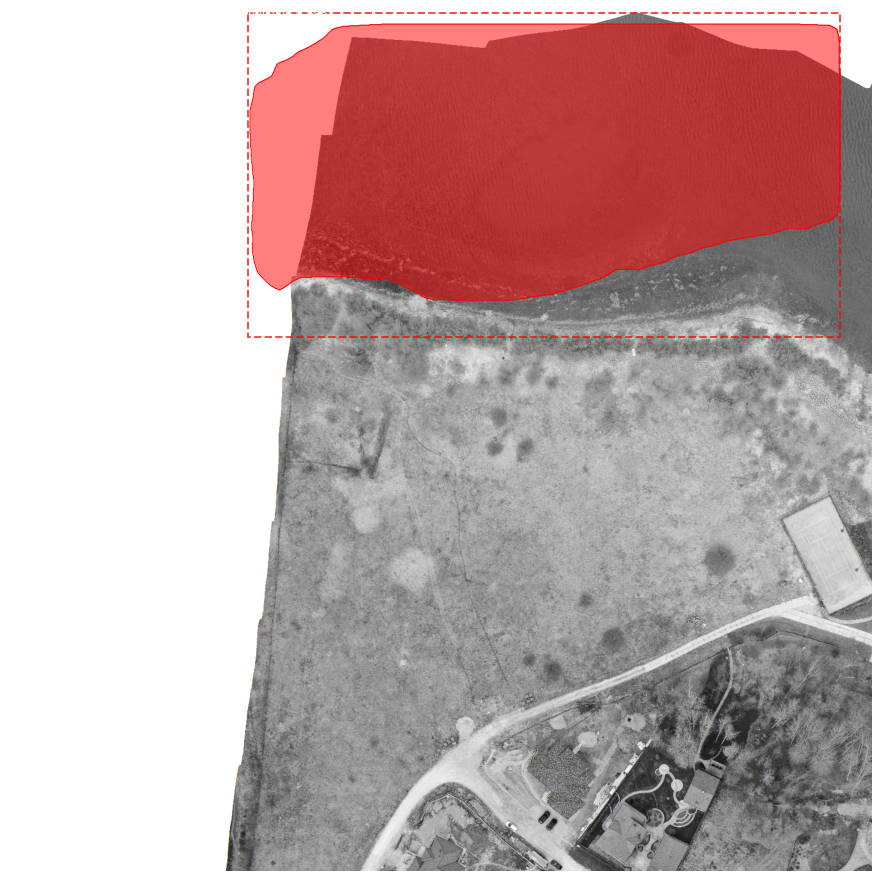

Mask found


In [138]:
x_coords = np.array([])
y_coords = np.array([])
for key in tiles.keys():
    #получаем тайл
    tile = tiles[key][:,:,:3]
    #предиктим его
    pred = model.detect([tile])[0]
    #смотрим, если на нём есть что-то(если нет выделенных областей на изображении)
    if pred['rois'].shape[0] != 0:
        mask = pred['masks']
#         visualize.display_instances(tile, pred['rois'], pred['masks'], pred['class_ids'], 
#                                    ['','building'],pred['scores'])
        print('Mask found')
        break #убираем брейк
        
        x = []
        y = []
        mask_ = mask[:, :, 0]
        for j in range(mask_.shape[0]):
            for k in range(mask_.shape[1]):
                if mask_[j, k] == True:
                    x_, y_ = pixel2coord(j + keys[0], k + keys[1])
                    x.append(x_)
                    y.append(y_)
        
        x_coords = np.concatenate(x_coords, np.array(x_)) #тут лежат х для полигонов на картинке
        y_coords = np.concatenate(y_coords, np.array(y_)) #тут y


In [148]:
#Находим в массиве bool == True ??
x = []
y = []
mask_ = mask[:, :, 0]
for j in range(mask_.shape[0]):
    for k in range(mask_.shape[1]):
        if mask_[j, k] == True: #if mask_[j, k]:
            x.append(j + key[0])
            y.append(i + key[1])

In [153]:
x, y = pixel2coord(np.array(x), np.array(y))

In [156]:
x

array([35.80410151, 35.80410151, 35.80410151, ..., 35.80447899,
       35.80447899, 35.80447899])

In [157]:
y

array([55.83695429, 55.83695429, 55.83695429, ..., 55.83695429,
       55.83695429, 55.83695429])